# Загрузка Order book из CSV

In [128]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [129]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [130]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history with (snapshot) where exchange='binance' and pair='ETH/USDT' and dt>'2018-09-23'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [131]:
df_history.shape

(892238, 11)

In [132]:
df_history.sort_values('dt').head()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-09-28 03:00:01,6263143,19,binance,ETH/USDT,229.100006,0.13100,None,sell,37645411.0,memory,2018-09-28 03:00:09.2400000
2018-09-28 03:00:01,6263144,19,binance,ETH/USDT,229.100006,5.67500,None,sell,37645414.0,memory,2018-09-28 03:00:09.2400000
2018-09-28 03:00:01,6263146,19,binance,ETH/USDT,229.130005,0.13311,None,buy,37645413.0,memory,2018-09-28 03:00:09.2400000
2018-09-28 03:00:01,6263145,19,binance,ETH/USDT,229.110001,0.25821,None,buy,37645412.0,memory,2018-09-28 03:00:09.2400000
2018-09-28 03:00:02,6263152,19,binance,ETH/USDT,229.139999,23.52187,None,buy,37645420.0,memory,2018-09-28 03:00:09.2400000


In [157]:
#выбор анализируемого диапазона и группировка по минутам
df_history_period = df_history['2018-09-28 0:00':'2018-10-03 0:00'].resample('T').mean()
df_history_period.head()

,rownum,id_ex_pair,price,amount,id
dt,,,,,
2018-09-28 03:00:00,6.263239e+06,19.0,229.256899,2.423739,37645475.0
2018-09-28 03:01:00,6.263551e+06,19.0,229.773098,4.159915,37645652.5
2018-09-28 03:02:00,6.263883e+06,19.0,230.053407,1.569706,37645834.5
2018-09-28 03:03:00,6.264154e+06,19.0,230.133126,2.291786,37645983.5
2018-09-28 03:04:00,6.264491e+06,19.0,229.775608,1.532065,37646137.5


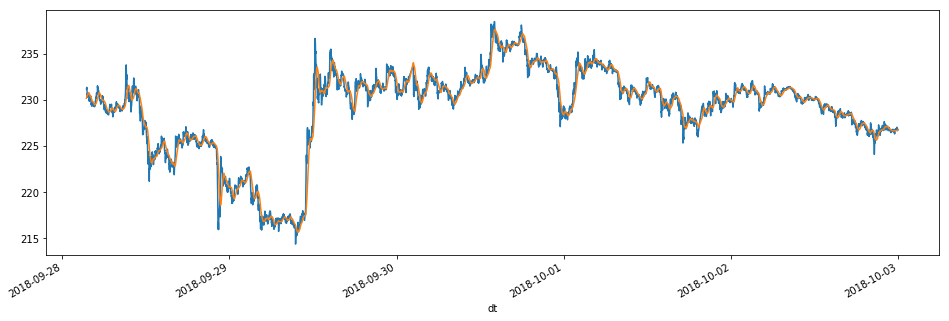

In [158]:
# выбор окна сдвига, удаление nan и график цены и скольз.среднего
window = 30

df_history_period['ma'] = df_history_period.price.rolling(window).mean()
df_history_period.dropna(inplace=True)
df_history_period.price.plot()
df_history_period.ma.plot(figsize=(16,5))

In [160]:
df_history_period.to_excel('ma_test.xlsx')

In [161]:
df_history_period.head(20)

,rownum,id_ex_pair,price,amount,id,ma
dt,,,,,,
2018-09-28 03:29:00,6.272527e+06,19.0,231.194364,4.492547,3.764983e+07,230.198124
2018-09-28 03:30:00,6.272738e+06,19.0,231.244252,5.902210,3.764993e+07,230.264369
2018-09-28 03:31:00,6.273003e+06,19.0,231.290890,2.199962,3.765002e+07,230.314962
2018-09-28 03:32:00,6.273248e+06,19.0,231.370465,3.758386,3.765011e+07,230.358864
2018-09-28 03:33:00,6.273458e+06,19.0,231.277896,7.438878,3.765019e+07,230.397023
2018-09-28 03:34:00,6.273793e+06,19.0,230.928273,5.586590,3.765030e+07,230.435445
2018-09-28 03:35:00,6.274193e+06,19.0,230.564545,4.874958,3.765043e+07,230.462242
2018-09-28 03:36:00,6.274466e+06,19.0,230.659143,1.273682,3.765055e+07,230.485578
2018-09-28 03:37:00,6.274763e+06,19.0,230.307525,2.464213,3.765066e+07,230.498344


In [162]:
df_history_period['IsUp'] = np.where(df_history_period.price > df_history_period.price.shift(1), 1, 0)

In [164]:
df_history_period['ma_signal'] = np.where(df_history_period.ma > df_history_period.price.shift(1), 1, 0)

In [166]:
df_history_period.head(15)

,rownum,id_ex_pair,price,amount,id,ma,IsUp,ma_signal
dt,,,,,,,,
2018-09-28 03:29:00,6.272527e+06,19.0,231.194364,4.492547,3.764983e+07,230.198124,0,0
2018-09-28 03:30:00,6.272738e+06,19.0,231.244252,5.902210,3.764993e+07,230.264369,1,0
2018-09-28 03:31:00,6.273003e+06,19.0,231.290890,2.199962,3.765002e+07,230.314962,1,0
2018-09-28 03:32:00,6.273248e+06,19.0,231.370465,3.758386,3.765011e+07,230.358864,1,0
2018-09-28 03:33:00,6.273458e+06,19.0,231.277896,7.438878,3.765019e+07,230.397023,0,0
2018-09-28 03:34:00,6.273793e+06,19.0,230.928273,5.586590,3.765030e+07,230.435445,0,0
2018-09-28 03:35:00,6.274193e+06,19.0,230.564545,4.874958,3.765043e+07,230.462242,0,0
2018-09-28 03:36:00,6.274466e+06,19.0,230.659143,1.273682,3.765055e+07,230.485578,1,0
2018-09-28 03:37:00,6.274763e+06,19.0,230.307525,2.464213,3.765066e+07,230.498344,0,0


In [180]:
#ma_accuracy = df_history_period.ma_signal.sum() / df_history_period.ma_signal.count()
df_history_period['ma_acc'] = np.where(df_history_period.ma_signal == df_history_period.IsUp, 1, 0)
ma_accuracy = df_history_period.ma_acc.sum() / df_history_period.ma_acc.count()
print ('MA accuracy = ', ma_accuracy)
# print(df_history_period.ma_signal.sum())
# print(df_history_period.ma_signal.count())

MA accuracy =  0.48946304849884525


In [179]:
df_history_period.head()

,rownum,id_ex_pair,price,amount,id,ma,IsUp,ma_signal,ma_acc
dt,,,,,,,,,
2018-09-28 03:29:00,6.272527e+06,19.0,231.194364,4.492547,37649833.5,230.198124,0,0,1
2018-09-28 03:30:00,6.272738e+06,19.0,231.244252,5.902210,37649932.0,230.264369,1,0,0
2018-09-28 03:31:00,6.273003e+06,19.0,231.290890,2.199962,37650020.5,230.314962,1,0,0
2018-09-28 03:32:00,6.273248e+06,19.0,231.370465,3.758386,37650108.5,230.358864,1,0,0
2018-09-28 03:33:00,6.273458e+06,19.0,231.277896,7.438878,37650189.5,230.397023,0,0,1
